# Tutorial 6: Simple Surface Processes

In [1]:
from underworld import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [4]:
# Characteristic values of the system
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
model_height = 120e3 * u.meter
refViscosity = 1e24 * u.pascal * u.second
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [5]:
Model = GEO.Model(elementRes=(144, 48), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [6]:
Model.outputDir="outputs_tutorial6.1_velSP"

In [7]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

In [8]:
air               = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0 * u.kilometer))
# stickyAir         = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer2D(top=air.bottom, bottom= 0.0 * u.kilometer))
uppercrust        = Model.add_material(name="UppperCrust", shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer2D(top=uppercrust.bottom, bottom=-100.0 * u.kilometer))
mantle            = Model.add_material(name="Mantle", shape=GEO.shapes.Layer2D(top=mantleLithosphere.bottom, bottom=Model.bottom))
sediment          = Model.add_material(name="Sediment")

In [9]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

# stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second
# stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [10]:
air.density                = 1. * u.kilogram / u.metre**3
# stickyAir.density          = 1. * u.kilogram / u.metre**3
uppercrust.density         = GEO.LinearDensity(reference_density=2620. * u.kilogram / u.metre**3)
mantleLithosphere.density  = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.density             = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
sediment.density           = GEO.LinearDensity(reference_density=2300. * u.kilogram / u.metre**3)

In [11]:
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
sediment.radiogenicHeatProd   = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

In [12]:
rh = GEO.ViscousCreepRegistry()

In [13]:
air.viscosity                = 1e19 * u.pascal * u.second
# stickyAir.viscosity          = 1e20 * u.pascal * u.second
uppercrust.viscosity         = 1 * rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
mantleLithosphere.viscosity  = rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
mantle.viscosity             = 0.2 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
sediment.viscosity         = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

In [14]:
plasticity = GEO.DruckerPrager(cohesion=20.0 * u.megapascal,
                               cohesionAfterSoftening=20 * u.megapascal,
                               frictionCoefficient=0.12,
                               frictionAfterSoftening=0.02,
                               epsilon1=0.5,
                               epsilon2=1.5)

In [15]:
uppercrust.plasticity         = plasticity
mantleLithosphere.plasticity  = plasticity
mantle.plasticity             = plasticity
sediment.plasticity           = plasticity


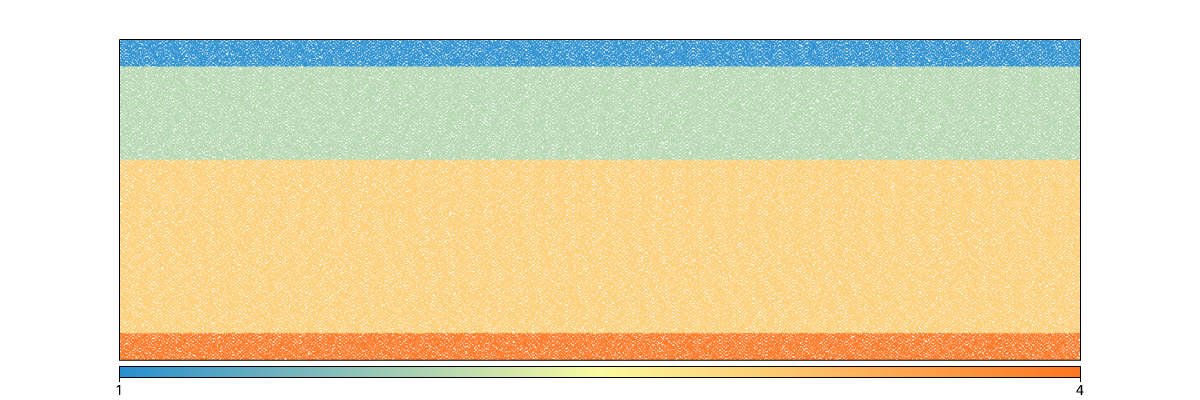

In [16]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

## Temperature Boundary Condition

In [17]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(mantle, 1603.15 * u.degK), (air, 293.15 * u.degK)])

## Velocity Boundary Conditions

In [18]:
Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, None],
                       right=[2.5 * u.centimeter / u.year, None],
                      top = [None, 0.])
#                        bottom=GEO.LecodeIsostasy(reference_mat=mantle, average=True))

## Initial Damage

In [19]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))

### x and y coordinates for the surface

In [20]:
import numpy as np

npoints = int(Model.length.magnitude)


coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(uppercrust.top)

### Include erosion and sedimentation rates in model runs

In [21]:
Model.surfaceProcesses = GEO.surfaceProcesses.velocitySurface_2D(
    airIndex=air.index,
    sedimentIndex=sediment.index,
    sedimentationRate= 2.*u.millimeter / u.year,
    erosionRate= 2.*u.millimeter / u.year,
    surfaceElevation=uppercrust.top,
    surfaceArray = coords
)







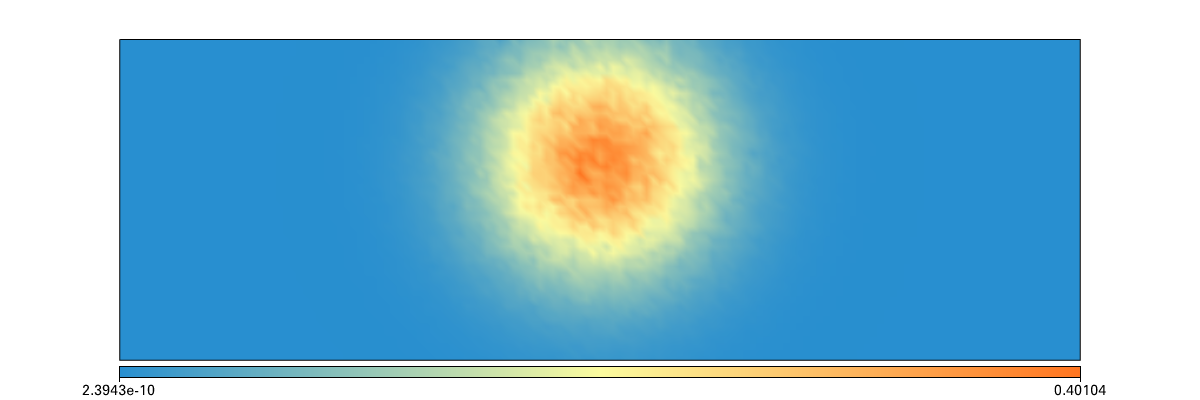

In [22]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.projPlasticStrain)
Fig.show()


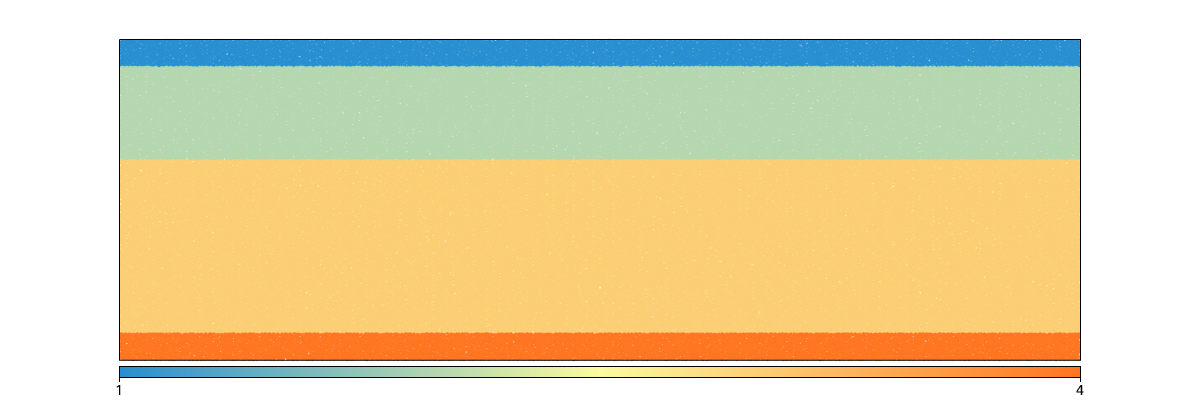

In [23]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()

In [24]:
Model.init_model()


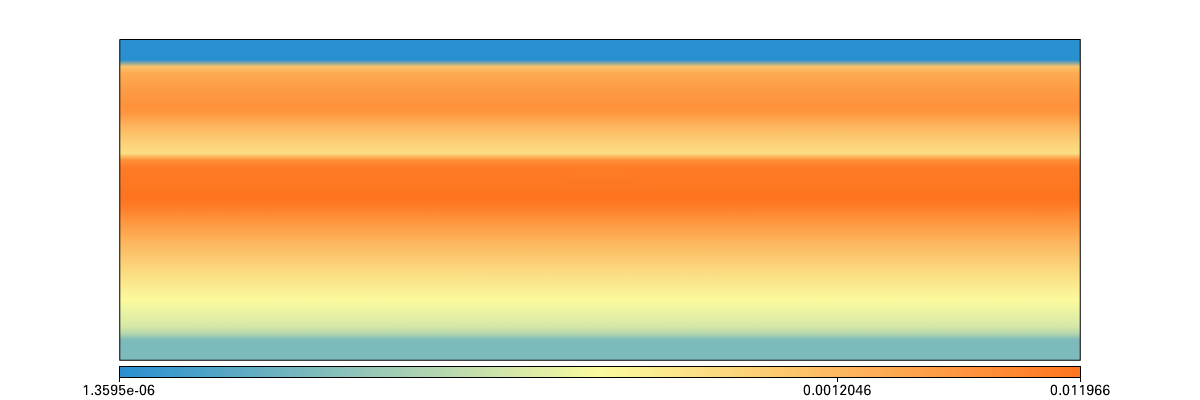

In [25]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.projViscosityField, logScale=True)
Fig.show()

In [26]:
Model.run_for(2.01 * u.megayear, checkpoint_interval=1.*u.megayears)

Running with UWGeodynamics version 2.10.2
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
SP total time: 41551.76 years, timestep: 6925.29 years, No. of its: 6
Step:     1 Model Time: 41551.8 year dt: 41551.8 year (2021-09-20 05:16:09)
SP total time: 41769.64 years, timestep: 6961.61 years, No. of its: 6
Step:     2 Model Time: 83321.4 year dt: 41769.6 year (2021-09-20 05:16:22)
SP total time: 41794.6 years, timestep: 6965.77 years, No. of its: 6
Step:     3 Model Time: 125116.0 year dt: 41794.6 year (2021-09-20 05:16:36)
SP total time: 41647.84 years, timestep: 6941.31 years, No. of its: 6
Step:     4 Model Time: 166763.8 year dt: 41647.8 year (2021-09-20 05:16:50)
SP total time: 41734.73 years, timestep: 6955.79 years, No. of its: 6
Step:    

1


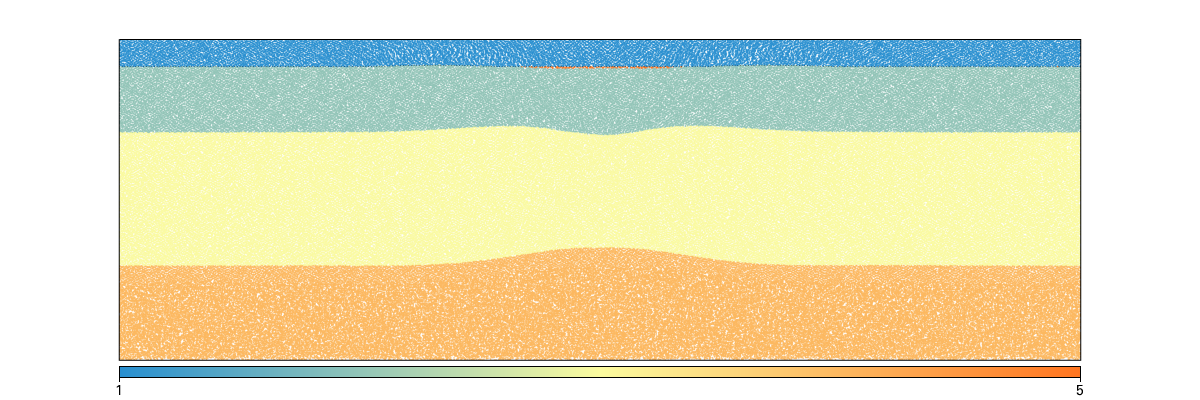

In [27]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
### output tracers
Fig.Points(Model.surfacetracers_tracers, pointSize=1.0)

# for line in lines:
#     Fig.Points(line, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()


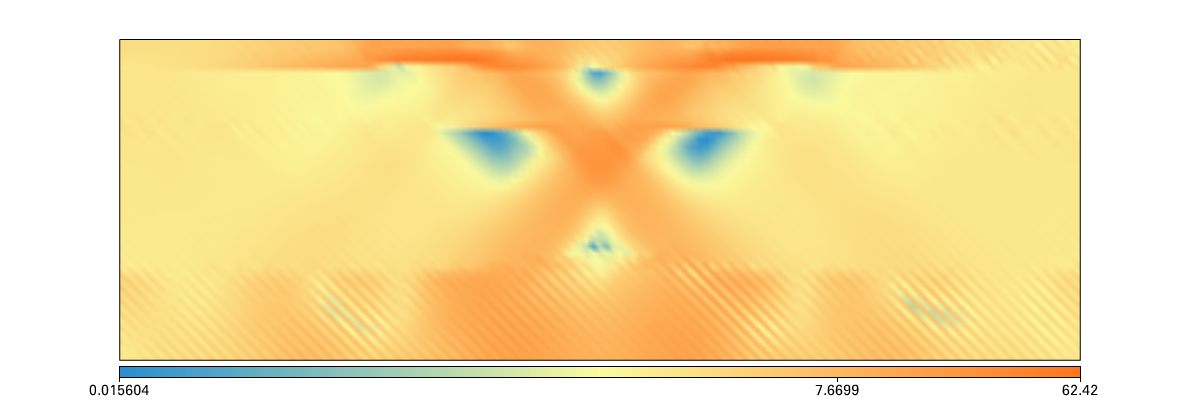

In [28]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.strainRate_2ndInvariant, logScale=True)
Fig.show()